In [1]:
import math
import random
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data_utils
from tqdm.notebook import tqdm
from livelossplot import PlotLosses

In [2]:
labels = {}
with open('/tmp/pycharm_project_856/data/dataset.tsv', 'r') as f:
    for n, line in enumerate(f.readlines()):
        items = line.split('\t')
        entity1 = items[0].strip()
        entity2 = items[1].strip()
        if entity1 not in labels:
            labels[entity1] = set()
        labels[entity1].add(entity2)
        if entity2 not in labels:
            labels[entity2] = set()
        labels[entity2].add(entity1)
        if len(labels) >= 200000:
            break
            
print('number of selected true labels', len(labels))

number of selected true labels 200000


In [3]:
max_len = 0
characters = set()

for normal, variants in labels.items():
    for variant in variants:
        characters.update(normal)
        characters.update(variant)
        if len(normal) > max_len:
            max_len = len(normal)
        if len(variant) > max_len:
            max_len = len(variant)
        
print('num of characters', len(characters))

characters.update(['[unk]', '[cls]', '[sep]', '[pad]'])
max_len *= 2 + 2

print('detected max len', max_len)
max_len = 70
print('max len set to', max_len)

num_embeddings = len(characters)

num of characters 41
detected max len 68
max len set to 70


In [4]:
character_to_idx = {}

for idx, character in enumerate(characters):
    character_to_idx[character] = idx    

with open("./models/character_to_idx.dat", "wb") as f:
    pickle.dump(character_to_idx, f)

character_to_idx

{'|': 0,
 'r': 1,
 'A': 2,
 'O': 3,
 'm': 4,
 '[pad]': 5,
 't': 6,
 '[unk]': 7,
 'h': 8,
 'l': 9,
 'J': 10,
 '3': 11,
 '0': 12,
 '9': 13,
 '[cls]': 14,
 '[sep]': 15,
 '2': 16,
 'n': 17,
 '8': 18,
 '6': 19,
 '4': 20,
 'p': 21,
 ' ': 22,
 '7': 23,
 'a': 24,
 'F': 25,
 'I': 26,
 'N': 27,
 '/': 28,
 'u': 29,
 'c': 30,
 'M': 31,
 'i': 32,
 '5': 33,
 '1': 34,
 'v': 35,
 'D': 36,
 's': 37,
 'y': 38,
 'b': 39,
 'o': 40,
 'e': 41,
 'S': 42,
 'g': 43,
 '.': 44}

In [5]:
train_x = []
train_y = []
valid_x = []
valid_y = []

def to_idxs(string):
    res = []
    for character in string:
        if character in character_to_idx:
            res.append(character_to_idx[character])
        else:
            res.append(character_to_idx['[unk]'])
    return res;

def get_x(entity1, entity2):
    x = [character_to_idx['[cls]']]
    x += to_idxs(entity1)
    x += [character_to_idx['[sep]']]
    x += to_idxs(entity2)
    return x

def add_padding(x):
    x += [character_to_idx['[pad]']] * (max_len - len(x))
    return x

# positive examples
print('generating positive labels')
for entity, variants in tqdm(labels.items()):
    for variant in variants:
        x = get_x(entity, variant)
        x = add_padding(x)
        train_x.append(x)
        train_y.append(1)

# negative examples
print('generating negative labels')
all_strings = list(labels.keys())
for entity, variants in labels.items():
    for variant in variants:
        all_strings.append(variant)
np.random.shuffle(all_strings)

all_strings_i = 0
for n, (entity, variants) in tqdm(enumerate(labels.items()), total=len(labels)):
    # this could be improved, by chance we may end up with a positive label marked negative
    for variant in all_strings[all_strings_i:all_strings_i + len(variants)]:
        x = get_x(entity, variant)
        x = add_padding(x)
        train_x.append(x)
        train_y.append(0)
    all_strings_i += len(variants)
        
print('splitting the dataset into 80% training and 20% validation')
train_xy = list(zip(train_x, train_y))
np.random.shuffle(train_xy)
train_x, train_y = zip(*train_xy)

split = int(len(train_x)*0.2)
valid_x, train_x = train_x[:split], train_x[split:]
valid_y, train_y = train_y[:split], train_y[split:]

generating positive labels



generating negative labels



splitting the dataset into 80% training and 20% validation


In [6]:
len(train_x), len(train_y), len(valid_x), len(valid_y)

(679704, 679704, 169926, 169926)

In [7]:
all_train_x = torch.tensor(train_x, dtype=torch.long)
all_train_y = torch.tensor(train_y, dtype=torch.long)
all_valid_x = torch.tensor(valid_x, dtype=torch.long)
all_valid_y = torch.tensor(valid_y, dtype=torch.long)

In [8]:
all_train_x.shape, all_train_y.shape, all_valid_x.shape, all_valid_y.shape

(torch.Size([679704, 70]),
 torch.Size([679704]),
 torch.Size([169926, 70]),
 torch.Size([169926]))

In [9]:
batch_size = 512+128

train_set = data_utils.TensorDataset(all_train_x, all_train_y)
train_loader = data_utils.DataLoader(train_set, batch_size = batch_size, shuffle=True)

valid_set = data_utils.TensorDataset(all_valid_x, all_valid_y)
valid_loader = data_utils.DataLoader(valid_set, batch_size = batch_size, shuffle=False)

In [10]:
class PositionalEncoding:
    
    def __init__(self, embedding_dim, max_len=100):
        self.pe = torch.zeros(max_len, embedding_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2).float() * (-math.log(10000.0) / embedding_dim))
        self.pe[:, 0::2] = torch.sin(position * div_term)
        self.pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = self.pe.to(device)
        
    def encode(self, x):
        return x + self.pe

In [11]:
class Model(nn.Module):
    
    def __init__(self, 
                 num_embeddings, 
                 embedding_dim, 
                 nhead=12, num_layers=3, dim_feedforward=1024, max_len=100):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.embed = nn.Embedding(num_embeddings, embedding_dim)
        self.pos_encoder = PositionalEncoding(embedding_dim, max_len)
        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(embedding_dim, nhead, dim_feedforward, activation='gelu'), num_layers)
        self.fc1 = nn.Linear(embedding_dim*max_len, (int) (embedding_dim/2))
        self.fc2 = nn.Linear((int) (embedding_dim/2), 2)
        self.criterion = nn.CrossEntropyLoss()
    
    def forward(self, x, y=None):
        y_pred = self.embed(x)
        y_pred = self.pos_encoder.encode(y_pred) * math.sqrt(self.embedding_dim)  
        y_pred = self.transformer_encoder(y_pred)
        y_pred = y_pred.reshape((y_pred.shape[0], -1))
        y_pred = self.fc1(y_pred)
        y_pred = self.fc2(y_pred)
        if y is None:
            y_pred = nn.functional.softmax(y_pred, dim=1)[:, 1]
            return y_pred
        else:
            return self.criterion(y_pred, y), y_pred

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [13]:
model = Model(num_embeddings, 192, max_len=max_len)
model = model.to(device)

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [15]:
def save_model(model):
    torch.save(model.state_dict(), './models/unigram_transformer.dat')

In [16]:
liveloss = PlotLosses()

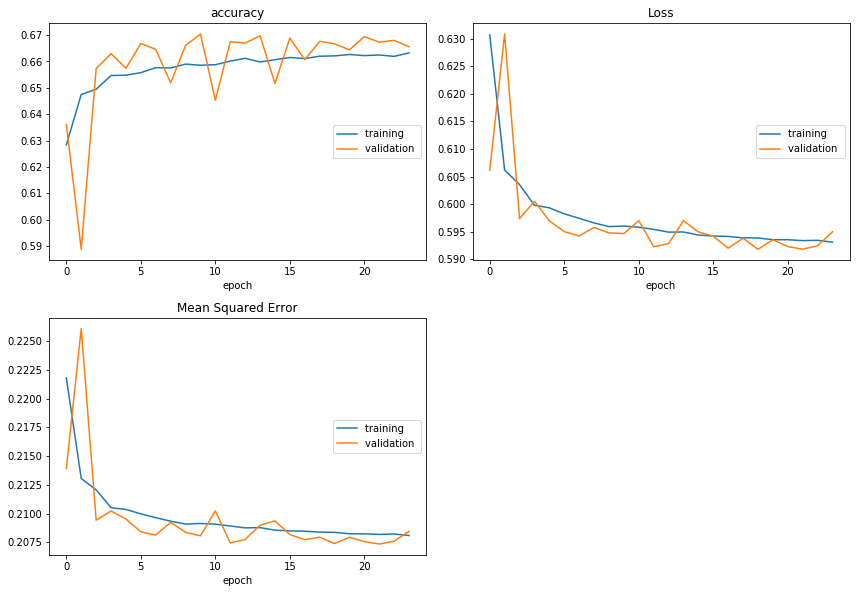

accuracy
	training         	 (min:    0.628, max:    0.663, cur:    0.663)
	validation       	 (min:    0.589, max:    0.670, cur:    0.666)
Loss
	training         	 (min:    0.593, max:    0.631, cur:    0.593)
	validation       	 (min:    0.592, max:    0.631, cur:    0.595)
Mean Squared Error
	training         	 (min:    0.208, max:    0.222, cur:    0.208)
	validation       	 (min:    0.207, max:    0.226, cur:    0.208)


In [17]:
data_loader = {'train':train_loader, 'valid':valid_loader}

current_valid_loss = 1.0
n_without_changing = 0
logs = {}
for epoch in range(200):
    
    for phase in ['train', 'valid']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        
        prefix = ''
        if phase == 'valid':
            prefix = 'val_'
            
        epoch_loss = 0.0
        epoch_corrects = 0
        epoch_se = 0.0
        for i, batch in tqdm(enumerate(data_loader[phase]), total=len(data_loader[phase].dataset) // batch_size):
            batch = [item.to(device) for item in batch]
            inputs, labels = batch
            # zero the parameter gradients
            if phase == 'train':
                optimizer.zero_grad()

            # forward + backward + optimize
            if phase == 'train':
                loss, output = model(inputs, labels)
                loss.backward()
                optimizer.step()
            else:
                with torch.no_grad():
                    loss, output = model(inputs, labels)

            # print statistics
            loss = loss.cpu().detach()
            output = output.cpu().detach()
            labels = labels.cpu().detach()
            epoch_loss += loss.item() * inputs.size(0)
            epoch_corrects += torch.sum(torch.max(output, 1)[1] == labels)
            epoch_se += torch.sum((nn.functional.softmax(output, dim=1)[:, 1] - labels)**2)
            
        epoch_loss /= len(data_loader[phase].dataset)
        logs[prefix + 'loss'] = epoch_loss
        logs[prefix + 'accuracy'] = epoch_corrects.float() / len(data_loader[phase].dataset)
        logs[prefix + 'mse'] = epoch_se.item() / len(data_loader[phase].dataset)

        if phase == 'valid': 
            if epoch_loss < current_valid_loss:
                save_model(model)
                current_valid_loss = epoch_loss
                n_without_changing=0
            else:
                n_without_changing+=1
            
    liveloss.update(logs)
    liveloss.draw()
    
    # early stopping criterion
    if n_without_changing == 5:
        break